In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sys, os
import ndreg
from ndreg import preprocessor, registerer
import SimpleITK as sitk
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import skimage

## MetaData

In [2]:
matplotlib.rcParams['figure.figsize'] = (15.0, 12.0)
COLLECTION = 'ailey-dev'
EXPERIMENT = "Thy1eYFP_Control_9_upload20170919"
CHANNEL = "Ch1"
RES = 3
x_range = [0, 2160]
y_range = [0, 2560]
z_range = [0, 1425]
resolution = 3
SAVE_DIR = '../Data/Thy1eYFP/'
INTERN_CFG_DIR = './intern.cfg'

In [3]:
def get_img(col, exp, ch, res=3, intern_cfg = './intern.cfg'):
    rmt = BossRemote(cfg_file_or_dict=intern_cfg)
    return rmt, ndreg.download_image(rmt, col, exp, ch, res=res)

# Download brain volume and atlas

In [4]:
rmt, img = get_img(COLLECTION, EXPERIMENT, CHANNEL)
atlas = ndreg.download_ara(rmt, 50)

# Preprocessing

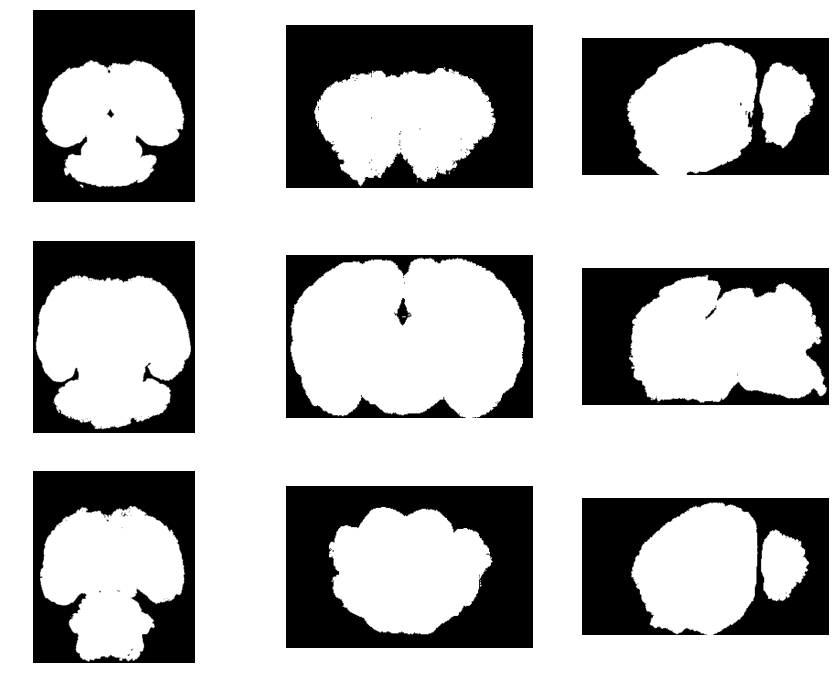

In [5]:
mask_sitk = preprocessor.create_mask(img, use_triangle=True)
ndreg.imgShow(mask_sitk, vmax=1)

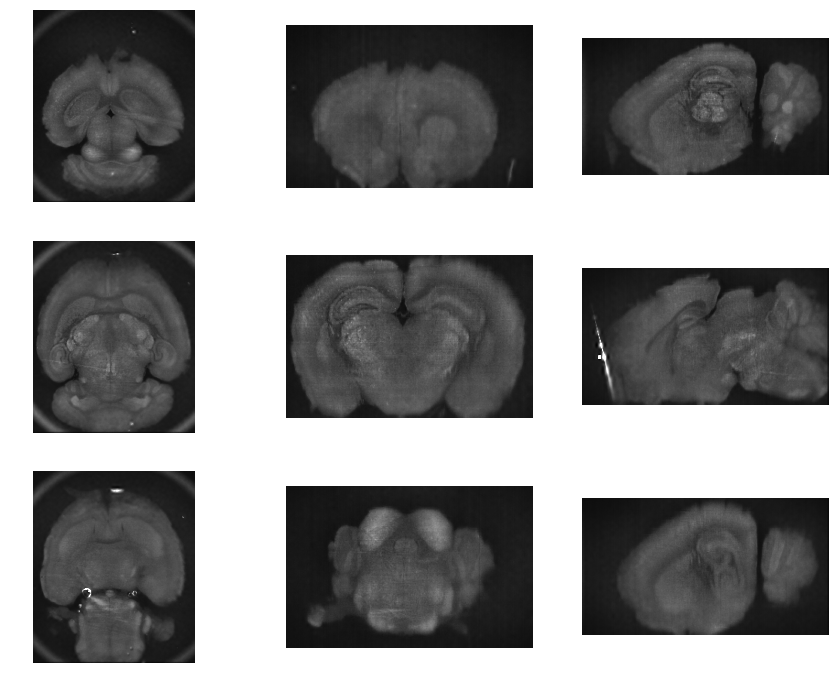

In [6]:
img_bc = preprocessor.correct_bias_field(img, scale=1.0,
                                         spline_order=4, num_control_pts=[5,5,5],
                                         niters=[200, 200, 200, 50])
ndreg.imgShow(img_bc, vmax=2500)

In [38]:
img_bc_ds = sitk.Normalize(atlas)
atlas_ds = sitk.Normalize(img_bc)
atlas_ds, img_bc_ds = preprocessor.downsample_and_reorient(img_bc_ds, atlas_ds, "pir", "lps", 0.05, default_value=ndreg.imgPercentile(img_bc_ds, 0.01))
ndreg.imgShow(atlas_ds)

TypeError: downsample_and_reorient() got an unexpected keyword argument 'default_value'

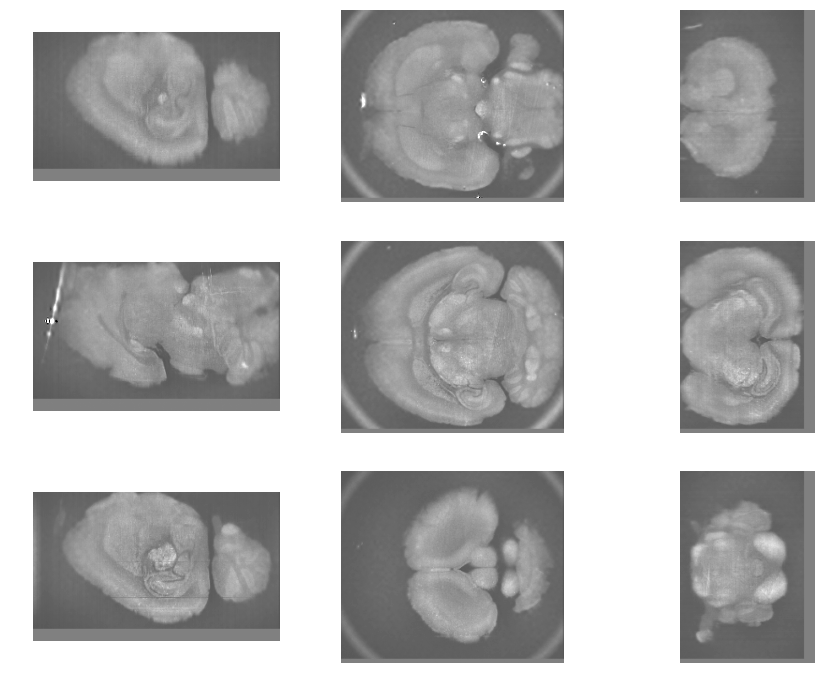

In [8]:
ndreg.imgShow(img_bc_ds, vmax=3, vmin=-3)

# Affine registration

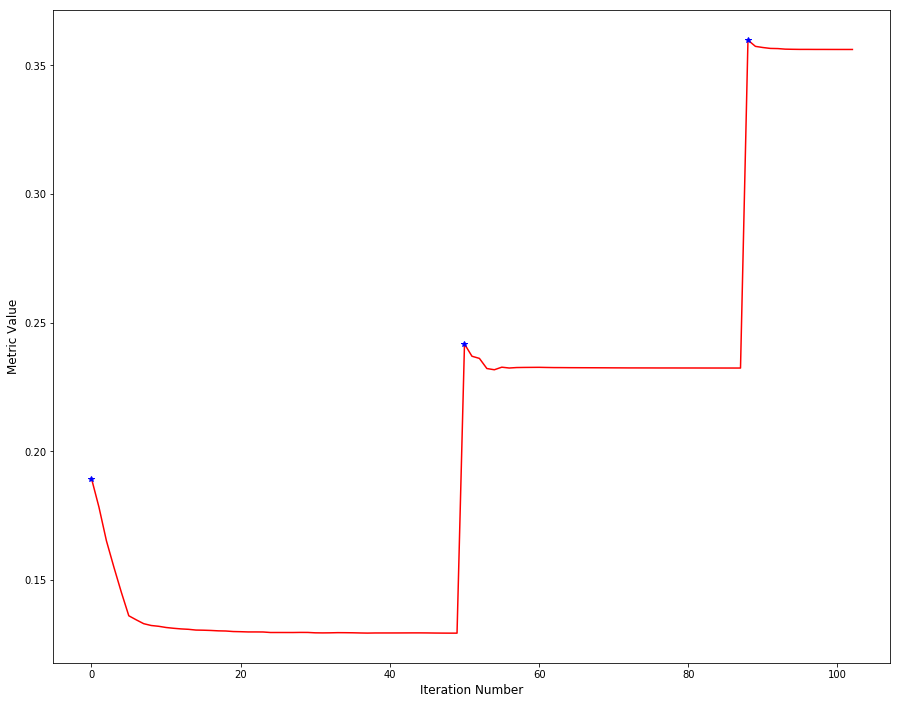

In [9]:
final_transform = registerer.register_affine(atlas_ds,
                                            img_bc_ds,
                                            learning_rate=1e-1,
                                            grad_tol=4e-6,
                                            use_mi=False,
                                            iters=50,
                                            shrink_factors=[4,2,1],
                                            sigmas=[0.6, 0.3, 0.150],
                                            verbose=True)

In [10]:
out_atlas = registerer.resample(atlas_ds, final_transform, atlas_ds)
out_target = registerer.resample(img_bc_ds, final_transform.GetInverse(), img_bc_ds)

In [11]:
img = sitk.GetArrayFromImage(out_atlas)

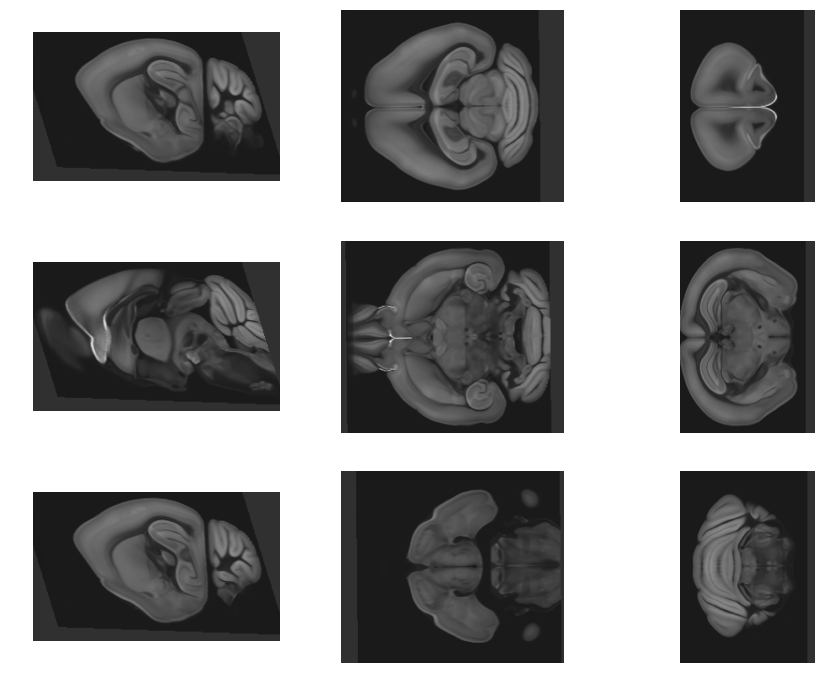

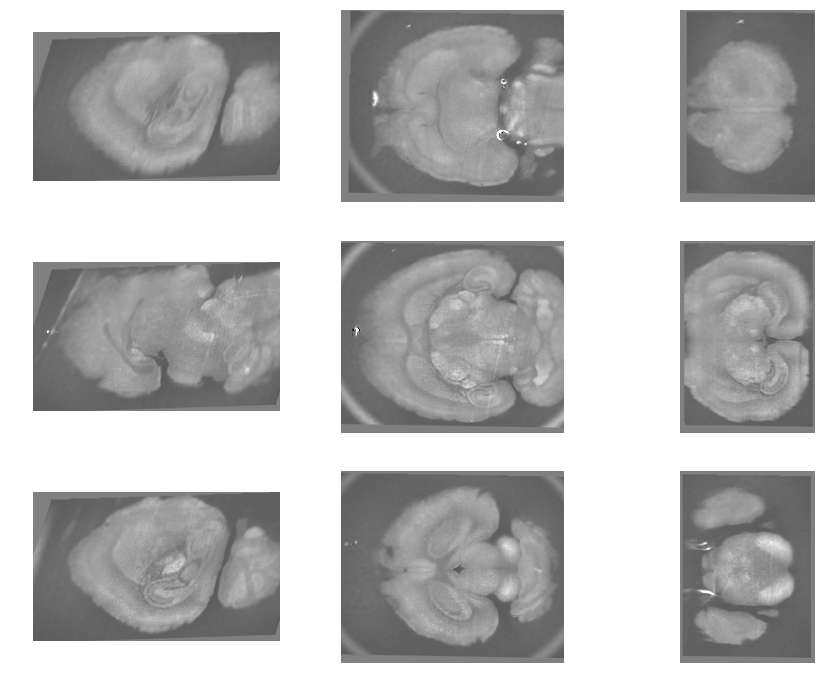

In [12]:
ndreg.imgShow(out_atlas)
ndreg.imgShow(out_target, vmax=3, vmin=-3)

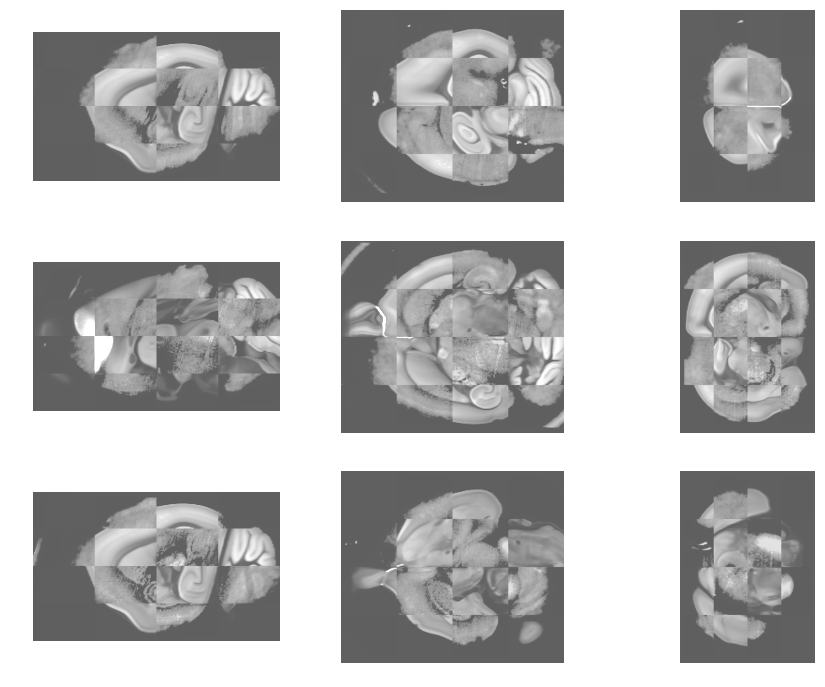

In [33]:
ndreg.imgShow(ndreg.imgChecker(out_target, sitk.Normalize(atlas)), vmax=3, vmin=-3)

# LDDMM registration

In [36]:
WHITEN_RADIUS = [5,5,5]
ALPHA = 0.25
BETA = 0.25

In [37]:
out_target_whitened = preprocessor.whiten(out_target, radius=WHITEN_RADIUS, alpha=ALPHA, beta=BETA)

TypeError: Required argument 'image1' (pos 1) not found

In [16]:
atlas_ds_whitened = preprocessor.whiten(atlas_ds, radius=WHITEN_RADIUS)

In [17]:
out_atlas_whitened = preprocessor.whiten(out_atlas, radius=WHITEN_RADIUS)
img_bc_ds_whitened = preprocessor.whiten(img_bc_ds, radius=WHITEN_RADIUS)

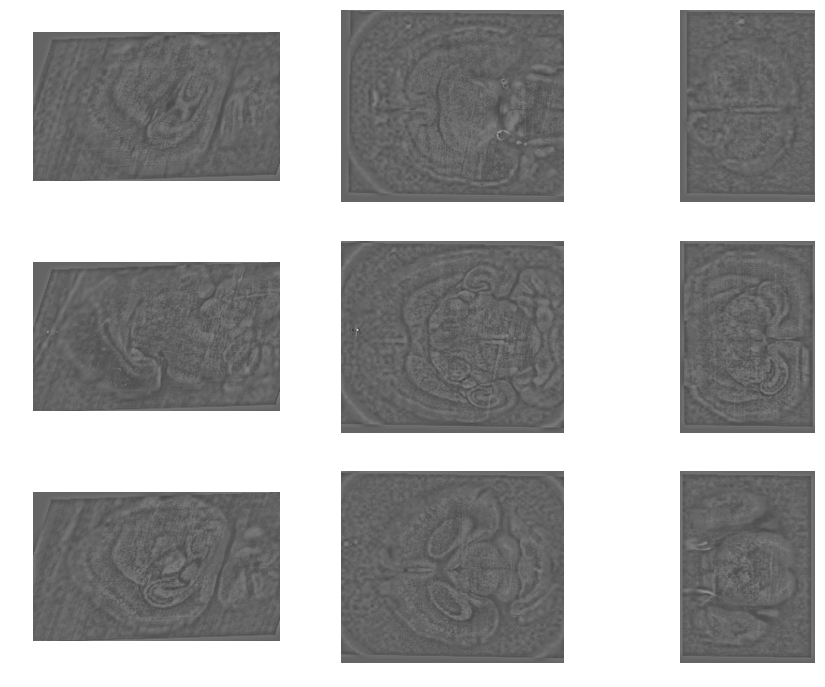

In [18]:
ndreg.imgShow(out_target_whitened)

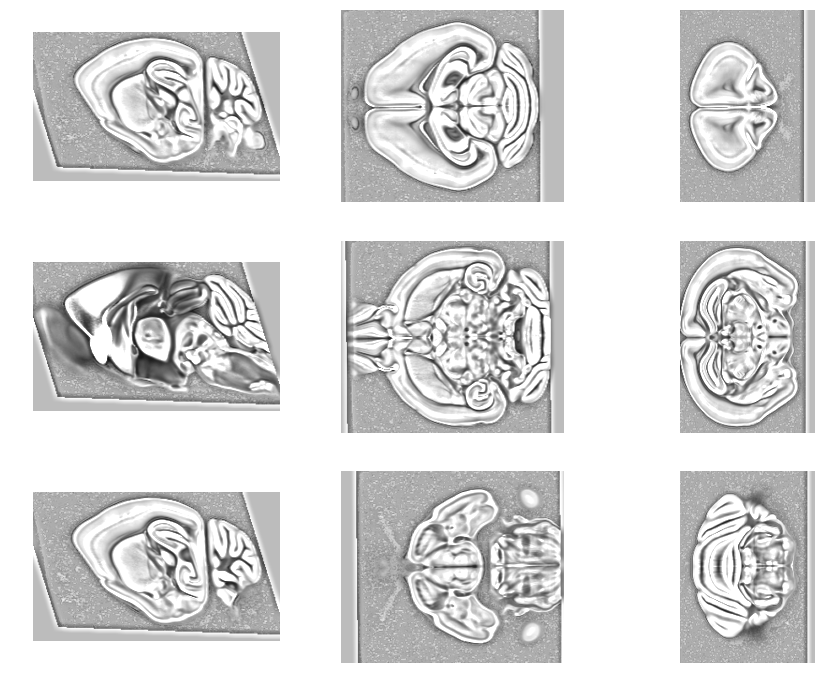

In [34]:
ndreg.imgShow(out_atlas_whitened, vmax=3)

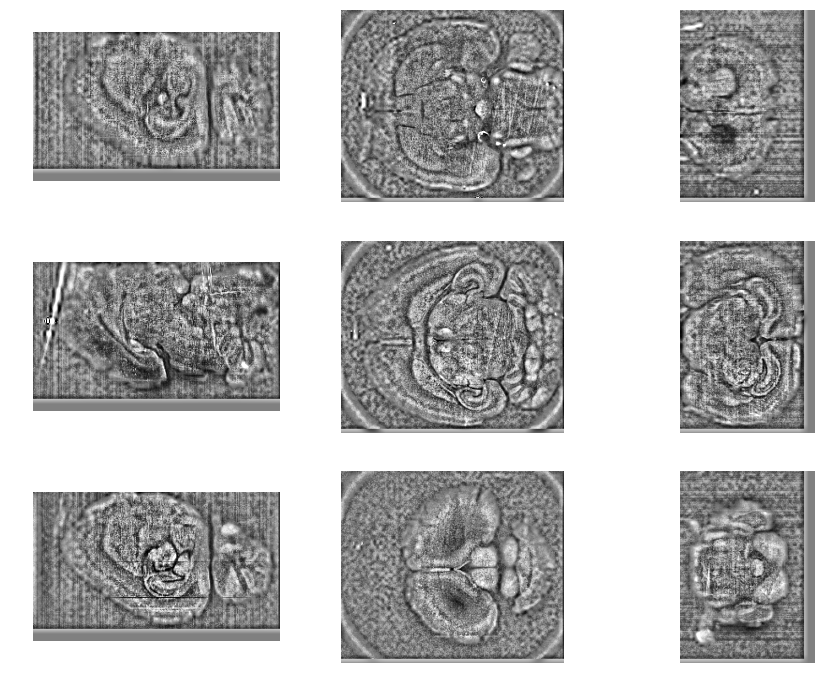

In [46]:
ndreg.imgShow(sitk.Normalize(img_bc_ds_whitened), vmin=-3, vmax=3)

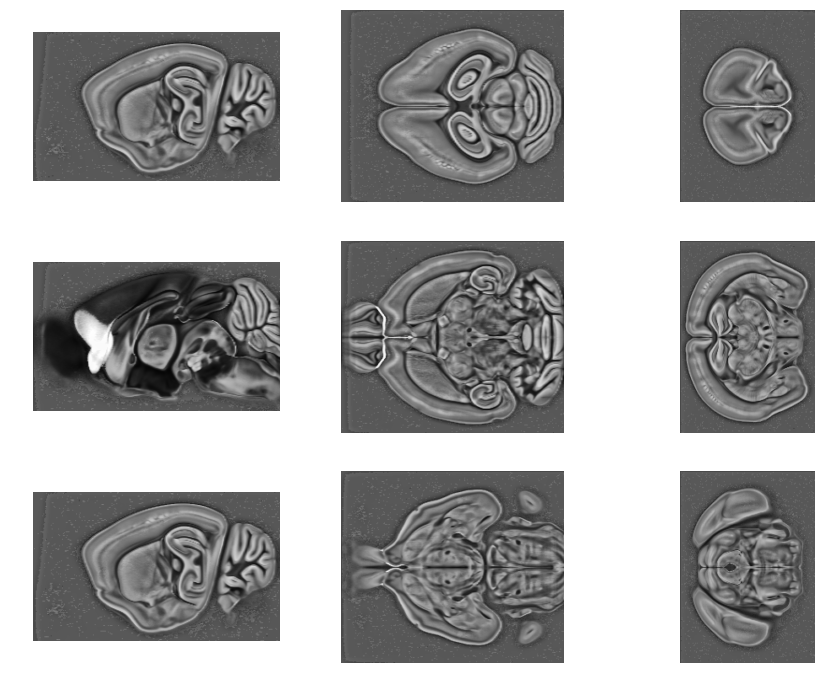

In [21]:
ndreg.imgShow(atlas_ds_whitened)

In [22]:
atlas_lddmm, field, inv_field = registerer.register_lddmm(affine_img=sitk.Normalize(out_atlas_whitened), 
                                                          target_img=sitk.Normalize(img_bc_ds_whitened),
                                                          alpha_list=[0.05], 
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=7e-3, sigma=0.008,
                                                          min_epsilon_list=1e-10,
                                                          use_mi=False, iterations=50, verbose=True)


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	1.98973e+07, 142.315, 0, 1.98971e+07 (97.3811%), 1.503906e-05
1.	1.78331e+07, 216.107, 0, 1.78329e+07 (87.2784%), 1.654297e-05
2.	1.68207e+07, 323.905, 0, 1.68204e+07 (82.3227%), 1.819727e-05
3.	1.66547e+07, 340.35, 0, 1.66544e+07 (81.5104%), 2.502124e-06
4.	1.66138e+07, 357.43, 0, 1.66135e+07 (81.3101%), 2.752336e-06
5.	1.65002e+07, 377.492, 0, 1.64998e+07 (80.7537%), 3.027570e-06
6.	1.62915e+07, 401.212, 0, 1.62911e+07 (79.7326%), 3.330327e-06
7.	1.60582e+07, 428.563, 0, 1.60578e+07 (78.5905%), 3.663360e-06
8.	1.58117e+07, 460.189, 0, 1.58112e+07 (77.3836%), 4.029696e-06
9.	1.56657e+07, 496.857, 0, 1.56652e+07 (76.669%), 4.432665e-06
10.	1.54772e+07, 540.548, 0, 1.54766e+07 (75.7462%), 4.875932e-06
11.	1.52631e+07, 595.094, 0, 1.52625e+07 (74.6982%), 5.363525e-06
12.	1.48983e+07, 661.802, 0, 1.48977e+07 (72.9127%), 5.899878e-06
13.	1.46642e+07, 731.669, 0, 1.46635e+07 (71.7663%),


Step 4: alpha=0.05, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	9.60306e+06, 15088.1, 0, 9.58797e+06 (98.9552%), 7.700000e-03
1.	9.59557e+06, 15398.1, 0, 9.58017e+06 (98.8747%), 2.117500e-03
2.	9.57699e+06, 14799.2, 0, 9.5622e+06 (98.6892%), 2.329250e-03
3.	9.57279e+06, 14078, 0, 9.55871e+06 (98.6532%), 2.562175e-03
4.	9.5555e+06, 13739, 0, 9.54176e+06 (98.4783%), 2.818393e-03
5.	9.54808e+06, 13383.7, 0, 9.5347e+06 (98.4054%), 3.100232e-03
6.	9.53614e+06, 13291.8, 0, 9.52285e+06 (98.2831%), 3.410255e-03
7.	9.52881e+06, 13045.1, 0, 9.51576e+06 (98.21%), 3.751280e-03
8.	9.52456e+06, 13230, 0, 9.51133e+06 (98.1643%), 4.126408e-03
9.	9.51277e+06, 12961.9, 0, 9.4998e+06 (98.0453%), 4.539049e-03
10.	9.50745e+06, 12745.3, 0, 9.4947e+06 (97.9926%), 4.992954e-03
11.	9.50277e+06, 13450.8, 0, 9.48932e+06 (97.9371%), 5.492250e-03
12.	9.49927e+06, 14185.9, 0, 9.48508e+06 (97.8933%), 6.041475e-03
13.	9.496e+06, 15208.5, 0, 9.48079e+06 (97.849%), 6.645622e-03
14

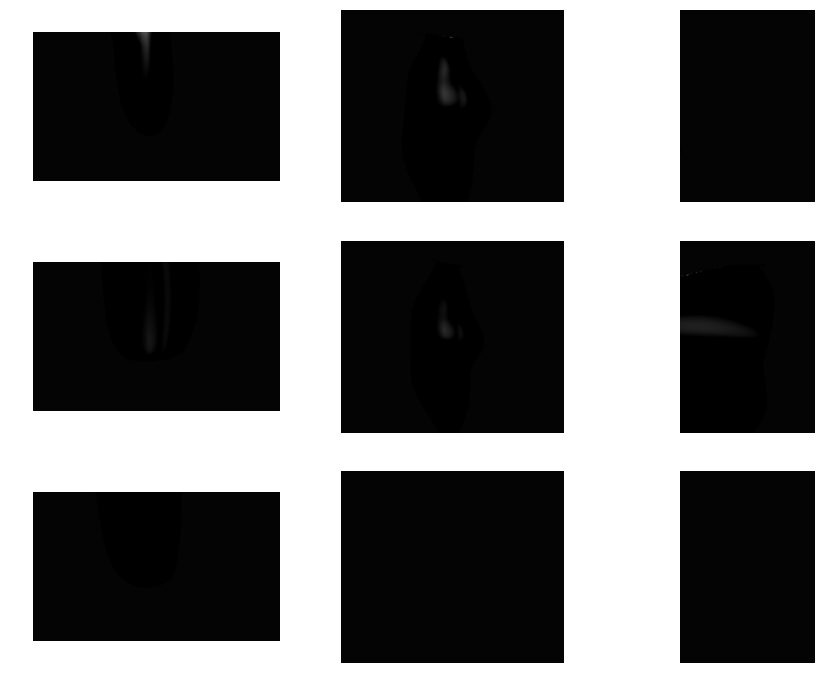

In [23]:
ndreg.imgShow(atlas_lddmm)

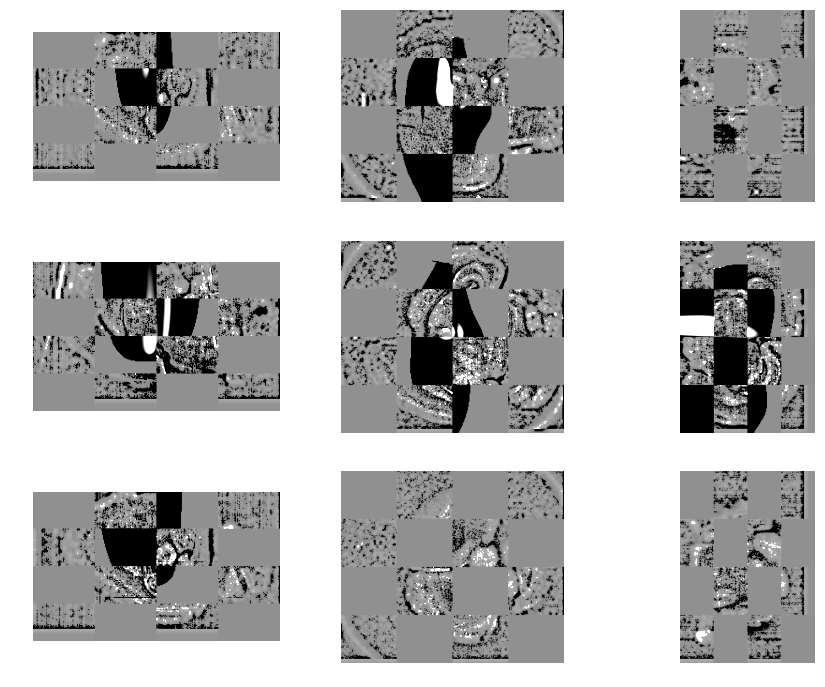

In [57]:
ndreg.imgShow(ndreg.imgChecker(sitk.Normalize(img_bc_ds_whitened), sitk.Normalize(atlas_lddmm)), vmax=1, vmin=-1)

In [35]:
atlas_lddmm, field, inv_field = registerer.register_lddmm(affine_img=sitk.Normalize(out_atlas_whitened), 
                                                          target_img=sitk.Normalize(out_target_whitened),
                         i                                 alpha_list=[0.05], 
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=7e-3, sigma=0.008,
                                                          min_epsilon_list=1e-10,
                                                          use_mi=False, iterations=50, verbose=True)


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	1.80854e+07, 423760, 0, 1.76616e+07 (96.9432%), 9.625000e-04
1.	1.73423e+07, 429488, 0, 1.69128e+07 (92.8329%), 1.323438e-04
2.	1.72661e+07, 430149, 0, 1.68359e+07 (92.411%), 3.639453e-05
3.	1.71952e+07, 430151, 0, 1.6765e+07 (92.0219%), 2.001699e-05
4.	1.70258e+07, 430098, 0, 1.65957e+07 (91.0922%), 2.201869e-05
5.	1.65422e+07, 430467, 0, 1.61117e+07 (88.4361%), 2.422056e-05
6.	1.65415e+07, 430467, 0, 1.6111e+07 (88.4321%), 5.203636e-08
7.	1.65414e+07, 430467, 0, 1.6111e+07 (88.4318%), 3.577500e-09
8.	1.65414e+07, 430467, 0, 1.61109e+07 (88.4317%), 9.838124e-10
9.	1.65414e+07, 430467, 0, 1.61109e+07 (88.4317%), 5.410968e-10
10.	1.65414e+07, 430467, 0, 1.61109e+07 (88.4316%), 2.976033e-10
E = 1.65772e+07 (88.6281%)
Length = 667.956
Time = 29.5723s (0.492871m)

Step 1: alpha=0.05, beta=0.05, scale=0.125
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	1.13676e+07, 75043.

KeyboardInterrupt: 